# Assignment #2

### Group 4

Lars Wrede, Dennis Blaufuss, Nicolas Kepper, Sophie Merl, Philipp Voit
___


In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, validation_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time
from matplotlib import cm
%matplotlib inline
import warnings
import random
warnings.filterwarnings("ignore")

___
### Introduction
Within the context of machine learning SVM plays a major role in spam detections and filtering. For this reason, we found a vectorized email spam dataset online and decided to use that for this assignment. We will not only implement a nonlinear kernel classification based on SVM, we also evaluate its performance with different types of kernels (linear kernel, polynomial kernel & Gaussian radial basis function) and check who comes out top.

 Let's load the dataset first and check that the classes are at least relatively balanced. 

In [2]:
random.seed(1)
url = 'https://raw.githubusercontent.com/ustunb/classification-pipeline/master/Data/Raw%20Data%20Files/spambase.csv'
spam = pd.read_csv(url,index_col=0,parse_dates=[0])

In [3]:
begin = time.time()

y = spam.index.to_numpy()
X = spam.to_numpy()

print(X.shape)
print('The portion of Spam mails: ' + str(round(y.sum() / len(y) * 100, 4)) + '%.')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

(4601, 57)
The portion of Spam mails: 39.4045%.


In [4]:
X_train.shape

(3680, 57)

We can see that it's not an exact 50/50 split, but 40/60 should still be more than fine.

---
### Metrics
We chose the following metrics to optimize for:

- $f0.2$ score
- $f0.5$ score

The $F_\beta$ is computed as follows:

$F_\beta=(1+\beta^2)\cdot \frac{precision  \cdot  recall}{\beta^2 \cdot precision + recall} = \frac{1+\beta^2}{\frac{1}{precision}+\frac{\beta^2}{recall}}$

Note that for the f-scores, we used betas of .2 and .5 (we will briefly use the f1-score as comparison later on). Of course, we want to make sure that our spam filter does its job and that spam mails do not enter our inbox, meaning that we want to avoid false negatives (assuming that spam mails are referred to as positive). However, even worse than finding some marketing mail in our inbox are false positives: A non-spam e-mail that is classified as spam might be more problematic. Thus, our emphasis should be on precision rather than on recall. Therfore, we always set beta significantly < 1.

Next, let's build ourselves two f-beta scorer so that we can evaluate and choose models later on. 

In [5]:
def f02_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta=0.2, pos_label=0, average='binary')

f02 = make_scorer(f02_scorer, greater_is_better=True)

def f05_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta=0.5, pos_label=0, average='binary')

f05 = make_scorer(f05_scorer, greater_is_better=True)

Before anything else, let's have a look at the effect of changing different hyperparameters on f0.2 and f0.5 score. We seperately look at the effects in a polynomial kernel and a rbf kernel here.

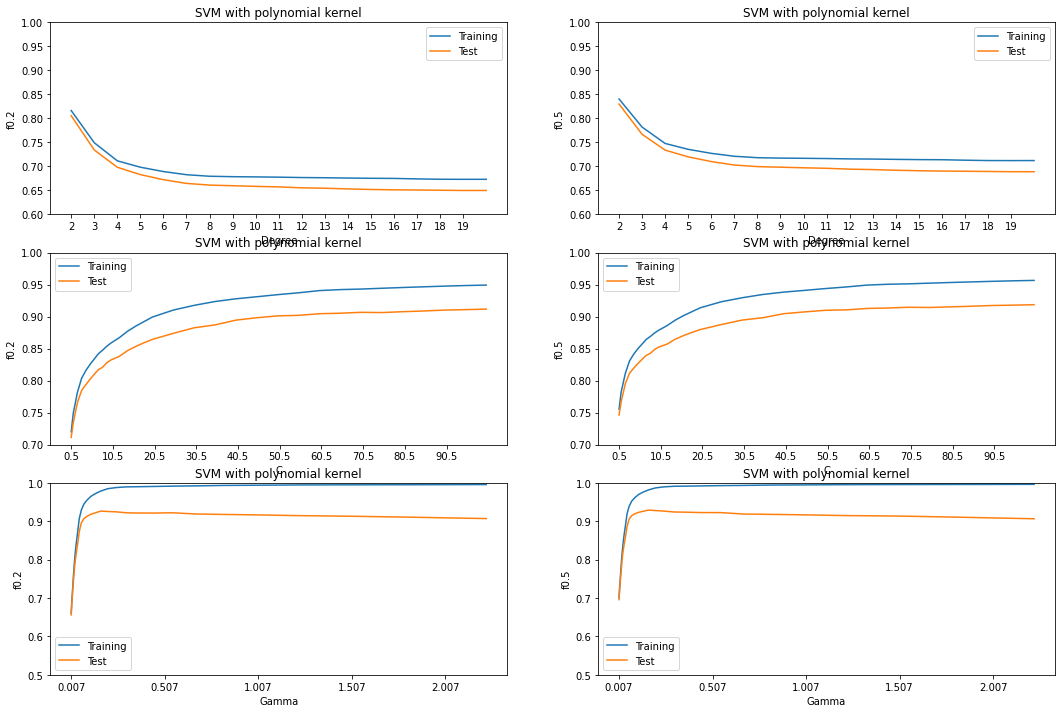

In [6]:
def plot_poly_curve(gammas='auto', Cs=1, degrees=3, scoring=f02):
    
    num_splits = 5               # use of k-fold is good
    kfold = KFold(n_splits = 5)  # random_state = 0
    
    if type(degrees) == np.ndarray:
        svm_poly = svm.SVC(kernel='poly', gamma=gammas, C=Cs)
        num_values = len(degrees)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                      param_name='degree', param_range=degrees, 
                                                      cv=kfold, scoring=scoring)
        xlabel = 'Degree'
        xtick = np.arange(degrees.min(), degrees.max(), 1)
        Xs = degrees
        ylim = [0.6, 1]
        
    elif type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel='poly', gamma=gammas, degree=degrees)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                      param_name='C', param_range=Cs, 
                                                      cv=kfold, scoring=scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.7, 1]
        
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel='poly', degree=degrees, C=Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                      param_name='gamma', param_range=gammas, 
                                                      cv=kfold, scoring=scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0.5, 1]
    
    else:
        raise TypeError

    train_scores = pd.DataFrame(data = train_scores, 
                                     index = np.arange(0, num_values), 
                                     columns = np.arange(0, num_splits)) 
    valid_scores = pd.DataFrame(data = valid_scores, 
                                     index = np.arange(0, num_values), 
                                     columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores.mean(axis=1), label='Training')
    plt.plot(Xs, valid_scores.mean(axis=1), label='Test')
    plt.xlabel(xlabel)
    
    if scoring == f02:
        plt.ylabel('f0.2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title(f'SVM with polynomial kernel')
    plt.legend()

    
plt.figure(figsize = (18, 12))

Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))
degrees = np.arange(2, 21, 1)
gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(3, 2, 1)
plot_poly_curve(degrees=degrees, scoring=f02)
plt.subplot(3, 2, 2)
plot_poly_curve(degrees=degrees, scoring=f05)
plt.subplot(3, 2, 3)
plot_poly_curve(Cs=Cs, scoring=f02)
plt.subplot(3, 2, 4)
plot_poly_curve(Cs=Cs, scoring=f05)
plt.subplot(3, 2, 5)
plot_poly_curve(gammas=gammas, scoring=f02)
plt.subplot(3, 2, 6)
plot_poly_curve(gammas=gammas, scoring=f05)

plt.show()

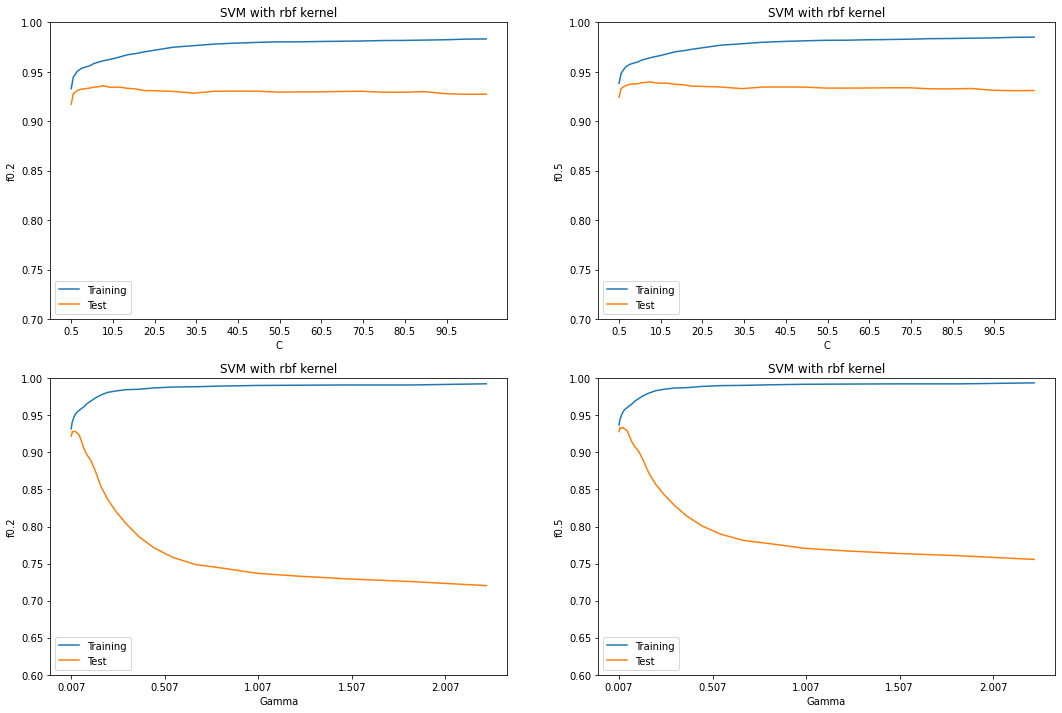

In [7]:
def plot_rbf_curve(gammas='auto', Cs=1, scoring=f02):
    
    num_splits = 5
    kfold = KFold(n_splits=5) 
    
    if type(Cs) == np.ndarray:
        svm_rbf = svm.SVC(kernel='rbf', gamma=gammas)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_rbf, X_train, y_train, 
                                                  'C', Cs, cv=kfold, 
                                                  scoring=scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.7, 1]
    elif type(gammas) == np.ndarray:
        svm_rbf = svm.SVC(kernel='rbf', C=Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_rbf, X_train, y_train, 
                                                  'gamma', gammas, cv=kfold, 
                                                  scoring=scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0.6, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data=train_scores, 
                                     index=np.arange(0, num_values), 
                                     columns=np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data=valid_scores,
                                     index=np.arange(0, num_values),
                                     columns=np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label='Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label='Test')
    plt.xlabel(xlabel)
    if scoring == f02:
        plt.ylabel('f0.2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with rbf kernel')
    plt.legend()

    
plt.figure(figsize=(18, 12))

Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))
gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(2, 2, 1)
plot_rbf_curve(Cs=Cs)
plt.subplot(2, 2, 2)
plot_rbf_curve(Cs=Cs, scoring=f05)
plt.subplot(2, 2, 3)
plot_rbf_curve(gammas=gammas)
plt.subplot(2, 2, 4)
plot_rbf_curve(gammas=gammas, scoring=f05)

plt.show()

As expected, the validation curves for all parameters look very similar - if not identical - when comparing f0.2 and f0.5 scores. 

Scores decrease for the polynomial kernel for higher degrees and don't show any zick-zack line as sometimes observeable. A reason therefore might be the big size of the dataset and its structure. Furthermore, scores increase when increasing C consistantly and increase rapidly until gamma reaches about 0.2 and then slowly converge to an f-score around 0.9.

For the rbf kernel, test scores are highest at gamma around 0.1, while C is hard to tell from this graph only (but it should be roughly between 10 and 20). Increasing gamma rapidly drops the scores while increasing c somwhat keeps the scores leveled, as expected.

___

Let's start training some models and see how well different hyperparameters work. Later on, we can optimize and tune them a bit more.

### Fitting the SVM to the data with different kernel functions

We will have to build a dataframe from results of modelfitting at least twice in this chapter, so let's create a function here to follow the standard programming pattern of not repeating oneself.

In [8]:
def create_parameter_result_df(model: GridSearchCV) -> pd.DataFrame:
    """
    Creates dataframe with Accuracy, Precision, Recall and f-scores for the given model
    
    Arguments:
    model - model to build the dataframe for
    
    Returns:
    DataFrame with aforementioned scores for the passed model
    
    """
    params = model.cv_results_['params']
    result = {k: [dic[k] for dic in params] for k in params[0]}
    cln = ['kernel', 'C', 'gamma', 'degree']
    
    for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f0.2', 'f0.5']:
        result['mean_test_' + i] = model.cv_results_['mean_test_' + i]
        result['std_test_' + i] = model.cv_results_['std_test_' + i]
        cln.append('mean_test_' + i)

    return pd.DataFrame(result), cln

In [9]:
start = time.time()

param_grid = {'kernel': ['poly', 'rbf', 'linear', 'sigmoid'],
              'C': [0.01, 0.1, 0.5, 1, 10],
              'gamma': [1 / X_train.shape[1], 0.01, 0.1, 1, 10],
              'degree': [2, 3, 4]}      

scoring = {'Accuracy': 'accuracy',
           'Precision': 'precision', 
           'recall': 'recall',
           'f1': 'f1', 
           'f0.5': f05,
           'f0.2': f02}

svm_ = svm.SVC()
CV_svm = GridSearchCV(estimator=svm_, param_grid=param_grid, cv=5, 
                      scoring=scoring, refit='f0.2')

CV_svm.fit(X_train, y_train)

time_spent = time.time() - start
print('time spent: ', time_spent)

time spent:  1525.5127964019775


In [10]:
results, cln = create_parameter_result_df(CV_svm)

We set parameter values to NaN where they're not needed and drop duplicates.

Then we sort by the f0.2 score and display the top 10 results.

### Optimization objetive according to our metrics

In [11]:
results.loc[results.kernel == 'linear', ['degree', 'gamma']] = np.nan
results.loc[results.kernel == 'rbf', 'degree'] = np.nan
results.loc[results.kernel == 'sigmoid', 'degree'] = np.nan

results.drop_duplicates(inplace=True) 
results_sorted02 = results.sort_values('mean_test_f0.2', ascending=False)
display(results_sorted02.loc[:,cln].head(10))

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f0.2,mean_test_f0.5
245,rbf,10.00,0.010000,NaN,0.936413,0.939565,0.898294,0.918333,0.935719,0.939948
182,linear,1.00,NaN,NaN,0.929076,0.921599,0.898294,0.909713,0.934534,0.936987
242,linear,10.00,NaN,NaN,0.928533,0.920917,0.897611,0.909011,0.934108,0.936553
241,rbf,10.00,0.017544,NaN,0.934511,0.937248,0.895563,0.915843,0.933995,0.938292
122,linear,0.50,NaN,NaN,0.927717,0.920754,0.895563,0.907913,0.932865,0.935520
62,linear,0.10,NaN,NaN,0.929076,0.926995,0.892150,0.909159,0.931354,0.934987
181,rbf,1.00,0.017544,NaN,0.929076,0.935787,0.882594,0.908238,0.926596,0.931983
268,poly,10.00,0.100000,3.0,0.916848,0.906075,0.882594,0.894142,0.924318,0.926826
32,poly,0.01,1.000000,3.0,0.916848,0.906075,0.882594,0.894142,0.924318,0.926826
185,rbf,1.00,0.010000,NaN,0.927717,0.937563,0.877133,0.906217,0.923545,0.929637


We can clearly see, that rbf kernels dominate the top models. Let's check - for safety - that we get the same picture when ordering by f0.5 scores and then we can retrain an rbf kernel with more options for the different hyperparameters. We will keep training a polynomial kernel as well for comparison reasons.

In [12]:
results_sorted05 = results.sort_values('mean_test_f0.5', ascending=False)
results_sorted05.drop_duplicates(subset = results_sorted05.columns[3:], inplace=True) 

display(results_sorted05.loc[:,cln].head(10))

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f0.2,mean_test_f0.5
245,rbf,10.0,0.010000,NaN,0.936413,0.939565,0.898294,0.918333,0.935719,0.939948
241,rbf,10.0,0.017544,NaN,0.934511,0.937248,0.895563,0.915843,0.933995,0.938292
182,linear,1.0,NaN,NaN,0.929076,0.921599,0.898294,0.909713,0.934534,0.936987
242,linear,10.0,NaN,NaN,0.928533,0.920917,0.897611,0.909011,0.934108,0.936553
122,linear,0.5,NaN,NaN,0.927717,0.920754,0.895563,0.907913,0.932865,0.935520
62,linear,0.1,NaN,NaN,0.929076,0.926995,0.892150,0.909159,0.931354,0.934987
181,rbf,1.0,0.017544,NaN,0.929076,0.935787,0.882594,0.908238,0.926596,0.931983
185,rbf,1.0,0.010000,NaN,0.927717,0.937563,0.877133,0.906217,0.923545,0.929637
268,poly,10.0,0.100000,3.0,0.916848,0.906075,0.882594,0.894142,0.924318,0.926826
125,rbf,0.5,0.010000,NaN,0.925272,0.938352,0.869625,0.902548,0.919466,0.926335


The rbf kernel generally performs better in different hyperparameter combos than the other kernel functions.

The rbf kernel has a relatively small gamma (0.01 to 1 / number of features) and large C (larger than 1, means less regularization). Therefore, it seems that C plays most important role in this training.

### Finding the optimal hyperparameters

We now have a rough idea of which models might be a good fit for our data. Let's refine the hyperparametergrids and find the models that yield the best fit out of these hyperparameter combinations. 

In [13]:
start = time.time()

C = np.append(np.append(np.arange(0.1, 1, 0.1), np.arange(1, 10, 1)), np.arange(10, 20, 2))
gamma = np.append(np.arange(0.002, 0.02, 0.002), 1 / X_train.shape[1])

param_grid = {'C': C, 'gamma': gamma}   

svm_rbf = svm.SVC(kernel='rbf', random_state=0)
CV_svm_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv = 5, 
                          scoring=scoring, refit='f0.2', return_train_score=True)

CV_svm_rbf.fit(X_train, y_train)
time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  579.5423166751862


In [14]:
start = time.time()

C = np.append(np.append(np.append(np.arange(1, 10, 1), np.arange(10, 20, 2)), np.arange(20, 120, 5)), np.arange(120, 150, 10))
gamma = np.append(np.append(np.append(np.arange(0.01, 0.03, 0.002), np.arange(0.03, 0.07, 0.005)), np.arange(0.07, 0.1, 0.01)), 1 / X_train.shape[1])
degree = np.arange(2, 5, 1)

param_grid = {'C': C, 'gamma': gamma, 'degree': degree}

svm_poly = svm.SVC(kernel='poly', random_state=0)
CV_svm_poly = GridSearchCV(estimator=svm_poly, param_grid=param_grid, cv=5,
                           scoring=scoring, refit='f0.2', return_train_score=True)
CV_svm_poly.fit(X_train, y_train)

time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  5130.652935743332


In [15]:
results_rbf, _ = create_parameter_result_df(CV_svm_rbf)
#display(results)

results_sorted_rbf = results_rbf.sort_values('mean_test_f0.2', ascending=False)
results_sorted_rbf.index = range(len(results_sorted_rbf))

In [16]:
results_poly, _ = create_parameter_result_df(CV_svm_poly)
#display(results_poly)

results_sorted_poly = results_poly.sort_values('mean_test_f0.2', ascending = False)
results_sorted_poly.index = range(len(results_sorted_poly))

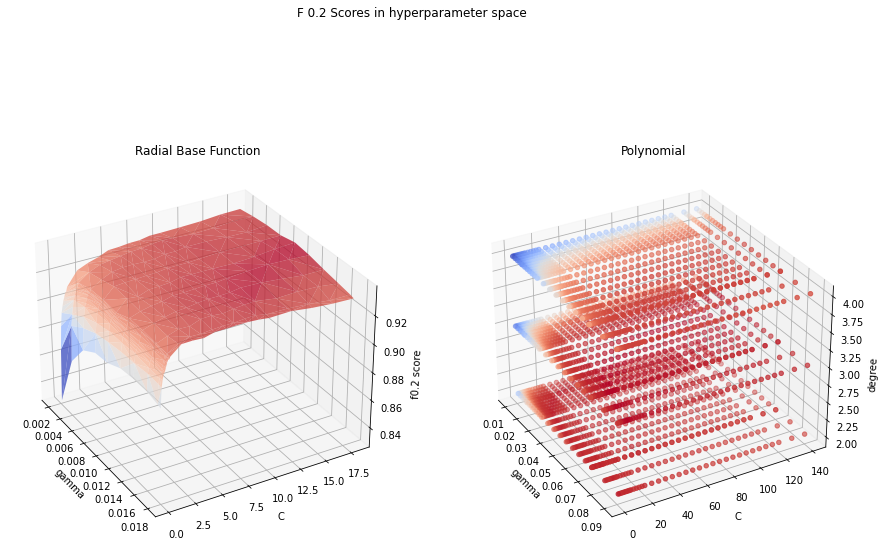

In [17]:
%matplotlib inline

fig = plt.figure(figsize = (15, 10))
fig.suptitle('F 0.2 Scores in hyperparameter space')
ax = plt.subplot2grid(shape=(1, 2), loc=(0, 0), fig=fig, projection='3d')
ax.plot_trisurf(results_rbf.gamma, results_rbf.C, results_rbf["mean_test_f0.2"], 
                cmap = cm.coolwarm, alpha = 0.75)
ax.set_xlabel('gamma')
ax.set_ylabel('C')
ax.set_zlabel('f0.2 score')
ax.view_init(azim=-30)
ax.set_title('Radial Base Function')

ax = plt.subplot2grid(shape=(1, 2), loc=(0, 1), fig=fig, projection='3d')
sc = ax.scatter(np.array(results_poly.gamma), np.array(results_poly.C), np.array(results_poly.degree),
    c=results_poly["mean_test_f0.2"], cmap=cm.coolwarm)
ax.set_xlabel('gamma')
ax.set_ylabel('C')
ax.set_zlabel('degree')
ax.view_init(azim=-30)
ax.set_title('Polynomial')
plt.show()

These graphs of the hyperparameter spaces can already give us slight intuitions of what might be the best values for the parameters. 

The left figure shows how the f0.2 score changes based on gamma and C for the rbf kernel. Darker red is equivalent to a higher f-score. In this figure the color is only needed since it is often hard to distinguish the details of the surfaces in this rather small surface plot.

The right figure shows the parameter grid for the polynomial kernel as a scatter plot. A surface plot obviously looks nicer but unfortunately us humans can only see in three dimensions, so for this hyperparameterspace we can use **only** color to indicate changes in the f-score. Again, darker red indicates higher f-scores.

For the rbf kernel, C will definitely be greater than 2 and gamma will most likely be in the range of 0.01. 
From the right figure we can draw similar conclusions. Degree will be either 2 or 3, gamma will most likely be higher than 0.02 and C - it's a bit hard to spot the differences in red shade - but it looks like C will be higher than 60.

We will see the actual best values in the next cells.

In [18]:
print(results_sorted_rbf.loc[0, ['C', 'gamma']])
svm_best_rbf = svm.SVC(C=results_sorted_rbf.loc[0, 'C'], 
                     gamma=results_sorted_rbf.loc[0, 'gamma'],
                     kernel='rbf')
svm_best_rbf.fit(X_train, y_train)

y_train_pred = svm_best_rbf.predict(X_train)
y_test_pred = svm_best_rbf.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

f02_train = f02_scorer(y_train, y_train_pred)
f02_test = f02_scorer(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f02 score of training sample: ', f02_train)
print('f02 score of test sample: ', f02_test)

C        18.00
gamma     0.01
Name: 0, dtype: float64
Confusion matrix of training sample: 
 [[2173   42]
 [  93 1372]]
Confusion matrix of test sample: 
 [[547  26]
 [ 39 309]]
f02 score of training sample:  0.9597893485093011
f02 score of test sample:  0.9342442356959862


In [19]:
print(results_sorted_poly.loc[0, ['C', 'gamma', 'degree']])
svm_best_poly = svm.SVC(C=results_sorted_poly.loc[0, 'C'], 
                     gamma=results_sorted_poly.loc[0, 'gamma'],
                     degree=results_sorted_poly.loc[0, 'degree'],
                     kernel='poly')
svm_best_poly.fit(X_train, y_train)

y_train_pred = svm_best_poly.predict(X_train)
y_test_pred = svm_best_poly.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

f02_train = f02_scorer(y_train, y_train_pred)
f02_test = f02_scorer(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f02 score of training sample: ', f02_train)
print('f02 score of test sample: ', f02_test)

C         120.000
gamma       0.035
degree      3.000
Name: 0, dtype: float64
Confusion matrix of training sample: 
 [[2210    5]
 [  47 1418]]
Confusion matrix of test sample: 
 [[552  21]
 [ 40 308]]
f02 score of training sample:  0.9798772169167803
f02 score of test sample:  0.933584856566708


The observed f0.2 scores are very satisfying. Our dataset is rather complex and spam detection is not necessarily an easy task given the ambiguity of natural words as well as characters in different contexts and thus we can't expect perfect f-scores.
Also, as expected, we can see that the test score of the rbf model is better than the test score of the polynomial model by a very slight margin (we also spent a lot more time optimizing the polynomial parameters, maybe we could still imporove the rbf kernel even more as well).
___

Let's quickly run almost the same code again and check the ideal hyperparameter combinations for the f1 score. We would expect to see a difference since the change in preference for/against precision/recall should be visible here.

In [20]:
results_sorted_rbf = results_rbf.sort_values('mean_test_f1', ascending=False)
results_sorted_rbf.index = range(len(results_sorted_rbf))

results_sorted_poly = results_poly.sort_values('mean_test_f1', ascending=False)
results_sorted_poly.index = range(len(results_sorted_poly))

print(results_sorted_rbf.loc[0, ['C', 'gamma']])
svm_best_rbf = svm.SVC(C=results_sorted_rbf.loc[0, 'C'], 
                     gamma=results_sorted_rbf.loc[0, 'gamma'],
                     kernel='rbf')
svm_best_rbf.fit(X_train, y_train)

y_train_pred = svm_best_rbf.predict(X_train)
y_test_pred = svm_best_rbf.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f1 score of training sample: ', f1_train)
print('f1 score of test sample: ', f1_test)

print(results_sorted_poly.loc[0, ['C', 'gamma', 'degree']])
svm_best_poly = svm.SVC(C=results_sorted_poly.loc[0, 'C'], 
                     gamma=results_sorted_poly.loc[0, 'gamma'],
                     degree=results_sorted_poly.loc[0, 'degree'],
                     kernel='poly')
svm_best_poly.fit(X_train, y_train)

y_train_pred = svm_best_poly.predict(X_train)
y_test_pred = svm_best_poly.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f1 score of training sample: ', f1_train)
print('f1 score of test sample: ', f1_test)

C        18.00
gamma     0.01
Name: 0, dtype: float64
Confusion matrix of training sample: 
 [[2173   42]
 [  93 1372]]
Confusion matrix of test sample: 
 [[547  26]
 [ 39 309]]
f1 score of training sample:  0.9531087183049669
f1 score of test sample:  0.9048316251830161
C         80.00
gamma      0.04
degree     3.00
Name: 0, dtype: float64
Confusion matrix of training sample: 
 [[2210    5]
 [  47 1418]]
Confusion matrix of test sample: 
 [[552  21]
 [ 40 308]]
f1 score of training sample:  0.981994459833795
f1 score of test sample:  0.9098966026587889


The rbf model gets the exact same parameters as the f0.2 optimized model - only the scores are a bit worse. The polynomial model changes a bit more, but still uses a third degree kernel.
Both models have a worse test score than the f0.2 models, and interestingly, now the polynomial model gets a slightly better score.

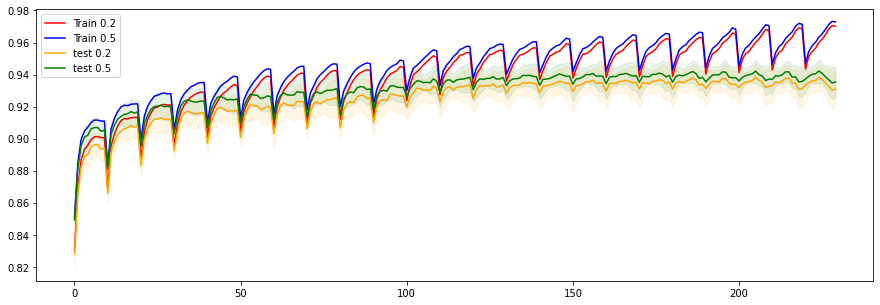

In [23]:
CV_svm_rbf.cv_results_['mean_test_f0.2']
idx = list(range(len(CV_svm_rbf.cv_results_['mean_test_f0.2'])))
fig = plt.figure(figsize=(15, 5))

plt.plot(idx, CV_svm_rbf.cv_results_['mean_train_f0.2'], color='red', label='Train 0.2')
plt.plot(idx, CV_svm_rbf.cv_results_['mean_train_f0.5'], color='blue', label='Train 0.5')

plt.plot(idx, CV_svm_rbf.cv_results_['mean_test_f0.2'], color='orange', label='test 0.2')
plt.fill_between(idx, 
                 CV_svm_rbf.cv_results_['mean_test_f0.2'] - CV_svm_rbf.cv_results_['std_test_f0.2'],
                 CV_svm_rbf.cv_results_['mean_test_f0.2'] + CV_svm_rbf.cv_results_['std_test_f0.2'],
                 facecolor='orange',
                 color='orange',
                 alpha=0.1)

plt.plot(idx, CV_svm_rbf.cv_results_['mean_test_f0.5'], color='green', label='test 0.5')
plt.fill_between(idx, 
                 CV_svm_rbf.cv_results_['mean_test_f0.5'] - CV_svm_rbf.cv_results_['std_test_f0.5'], 
                 CV_svm_rbf.cv_results_['mean_test_f0.5'] + CV_svm_rbf.cv_results_['std_test_f0.5'],
                 facecolor='green',
                 color='green',
                 alpha=0.1)

plt.legend()

When looking at the "shades" of our test scores we can observe that we don't have a big variance within our scores. Furthermore, there are no observable areas with significantly higher or lower variance. Thus, we have no reason to change our best hyperparameter combinations. In the case e. g. that we could observe a higher variance in the area where our chosen hyperparameters lay we would need to dig deeper into the analysis to find the true most desirable hyperparameters.

In [24]:
print('Runtime: ', time.time() - begin)

Runtime:  8096.872094869614
